# Exploratory analysis of electric data with weather

In [1]:
# import libs
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [3]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

## Feature Engineering

In [4]:
# time-based features
df['dow'] = df.index.weekday
df['weekday'] = (df.index.weekday < 5)*1
df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
df['hour'] = df.index.hour

In [5]:
# season-based features
# df['season'] = {}

df['winter'] = (df.index.month<=3)*1
df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
df['fall'] = (df.index.month>9)*1

In [6]:
df['mht_pct'] = df['main_house_total'].pct_change(1)
df['mht_pct'].dropna(axis=0,inplace=True)

## Feature Exploration

In [7]:
df[power_cols].describe()

,north_br,south_br,basement,dryer,washer,dining_room,dishwasher,workbench,security_system,refrigerator,...,dhw_heater,main_house_total,office,outside_plug,rental_suite,entertainment,utility_room,unmetered,whole_house_total,oven
count,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,...,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06,1.050780e+06
mean,1.041261e+00,2.436016e+01,3.838268e+01,5.307987e+01,4.380027e+00,6.670359e-01,1.493289e+01,1.208170e+01,3.991137e+01,5.043900e+01,...,7.287628e+00,8.603170e+02,3.544309e+01,7.382135e-03,2.503005e+02,4.098961e+01,4.693181e+01,1.986947e+02,1.112183e+03,7.887308e+00
std,8.920275e+00,3.615405e+01,1.016516e+02,4.900696e+02,3.698758e+01,2.740738e+00,1.043621e+02,2.218379e+01,2.728045e+00,7.042625e+01,...,7.503278e+00,8.268018e+02,3.012677e+01,4.297573e-01,4.122031e+02,5.720774e+01,1.134881e+01,2.864044e+02,9.461758e+02,1.479919e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,0.000000e+00,...,5.000000e+00,4.200000e+02,1.900000e+01,0.000000e+00,4.300000e+01,2.000000e+01,5.000000e+01,4.500000e+01,5.520000e+02,0.000000e+00
50%,0.000000e+00,7.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,0.000000e+00,...,5.000000e+00,5.440000e+02,2.700000e+01,0.000000e+00,1.750000e+02,2.200000e+01,5.100000e+01,1.080000e+02,7.580000e+02,0.000000e+00
75%,0.000000e+00,1.600000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,4.100000e+01,1.270000e+02,...,5.000000e+00,9.420000e+02,4.200000e+01,0.000000e+00,2.780000e+02,3.300000e+01,5.200000e+01,2.220000e+02,1.256000e+03,0.000000e+00
max,6.230000e+02,1.000000e+03,1.571000e+03,5.614000e+03,1.151000e+03,5.400000e+01,8.480000e+02,1.675000e+03,5.200000e+01,1.497000e+03,...,7.400000e+01,1.170600e+04,1.012000e+03,3.050000e+02,6.920000e+03,4.540000e+02,6.500000e+01,5.258000e+03,1.226000e+04,3.896000e+03


In [5]:
df[power_cols].sum().sort_values(ascending=False)

whole_house_total    1168659826
main_house_total      904003890
rental_suite          263010809
unmetered             208784368
heat_pump             176902907
furnace_fan           121307925
dryer                  55775269
refrigerator           53000294
utility_room           49315011
entertainment          43071061
security_system        41938066
basement               40331756
office                 37242894
south_br               25597174
dishwasher             15691187
workbench              12695213
oven                    8287825
dhw_heater              7657694
washer                  4602445
garage                  1645127
north_br                1094136
dining_room              700908
outside_plug               7757
dtype: int64

In [ ]:
# try to filter out times when each system is basically off
# perhaps do it by taking only top 75% of data?
df[power_cols][df[power_cols] > 10]

In [23]:
# is this useful for anything? 
pd.crosstab(df['hour'],df['dow'],values=df['main_house_total'],aggfunc='sum')

dow,0,1,2,3,4,5,6
hour,,,,,,,
0,7938756,6813435,6414900,6829382,6945651,6505366,6661135
1,6932385,7242297,6319149,6470640,7056236,6329554,7032038
2,7838983,7405386,7518767,7426847,7647569,7747668,7503579
3,7713461,6981291,7373469,7737411,6691884,7451657,7978700
4,7438643,7487791,7488927,7203698,7228099,7272569,7616365
5,6964403,8292544,7467123,7604216,7641725,7272004,7825372
6,5371098,5541361,5998889,6174233,6052164,5848605,6410606
7,3473083,3402913,4004726,3970863,4122410,3327176,4117591
8,2951251,2980582,3100480,3111119,3098128,3028540,3053703


## Histograms

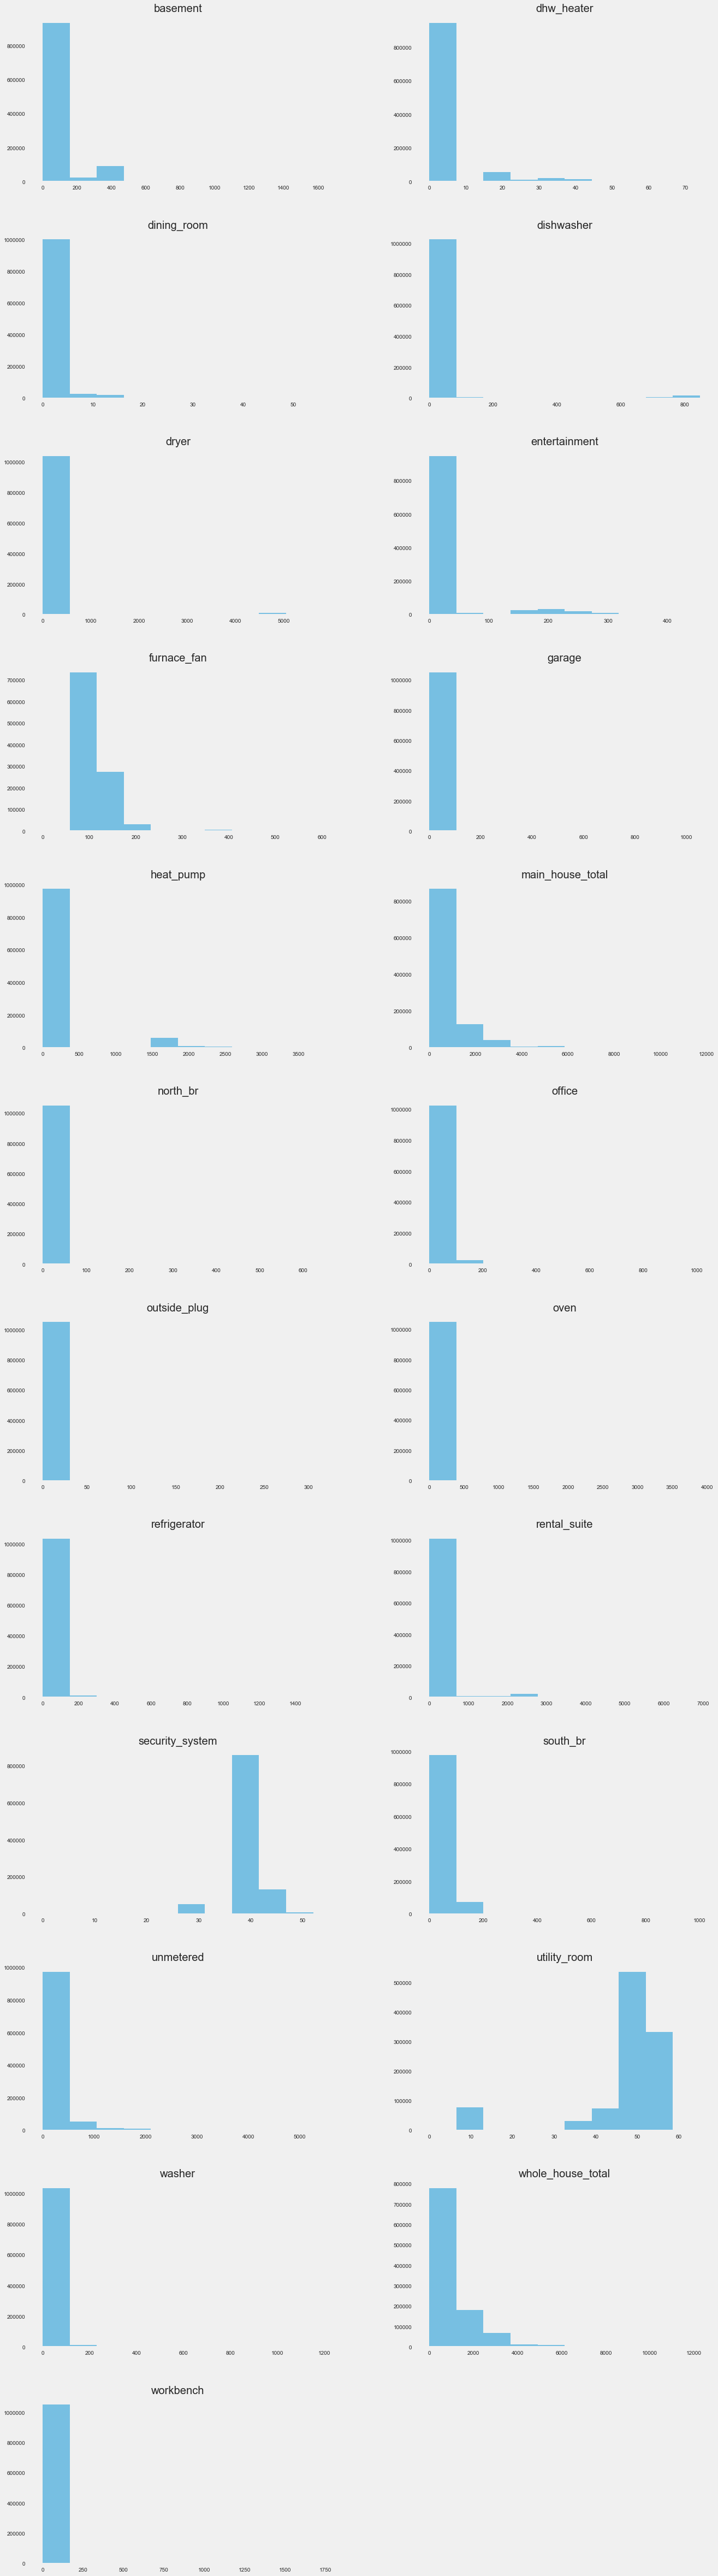

In [12]:
# need to standardize the bin size otherwise the comparison makes no sense
df[power_cols].hist(alpha=0.5,grid=False,layout=(12,2),figsize=(20,80));

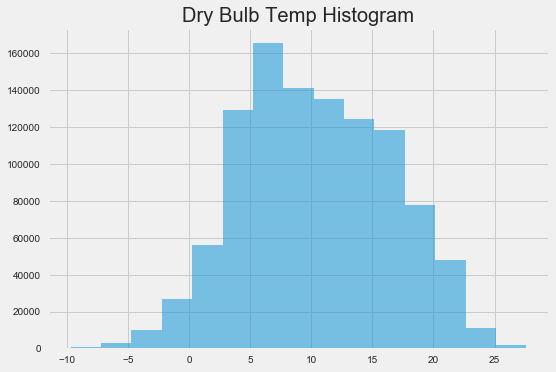

In [53]:
ax = df['Temp (C)'].hist(alpha=0.5,bins=15);
ax.set_title('Dry Bulb Temp Histogram');
# It doesn't get that hot in Canada (25 C is 77 F)

## Box Plots

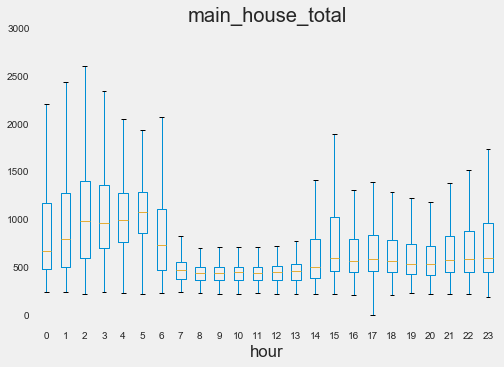

In [14]:
ax = df.boxplot(column='main_house_total',by ='hour',grid=False);
ax.set_ylim(-100,3000)
plt.suptitle(""); # get rid of stupid auto title

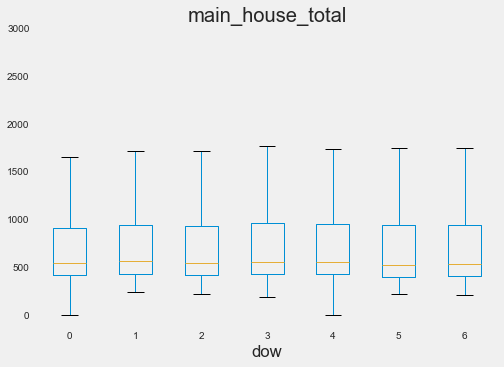

In [34]:
ax = df.boxplot(column='main_house_total',by ='dow',grid=False);
ax.set_ylim(-100,3000)
plt.suptitle(""); # get rid of stupid auto title

## Line Plots

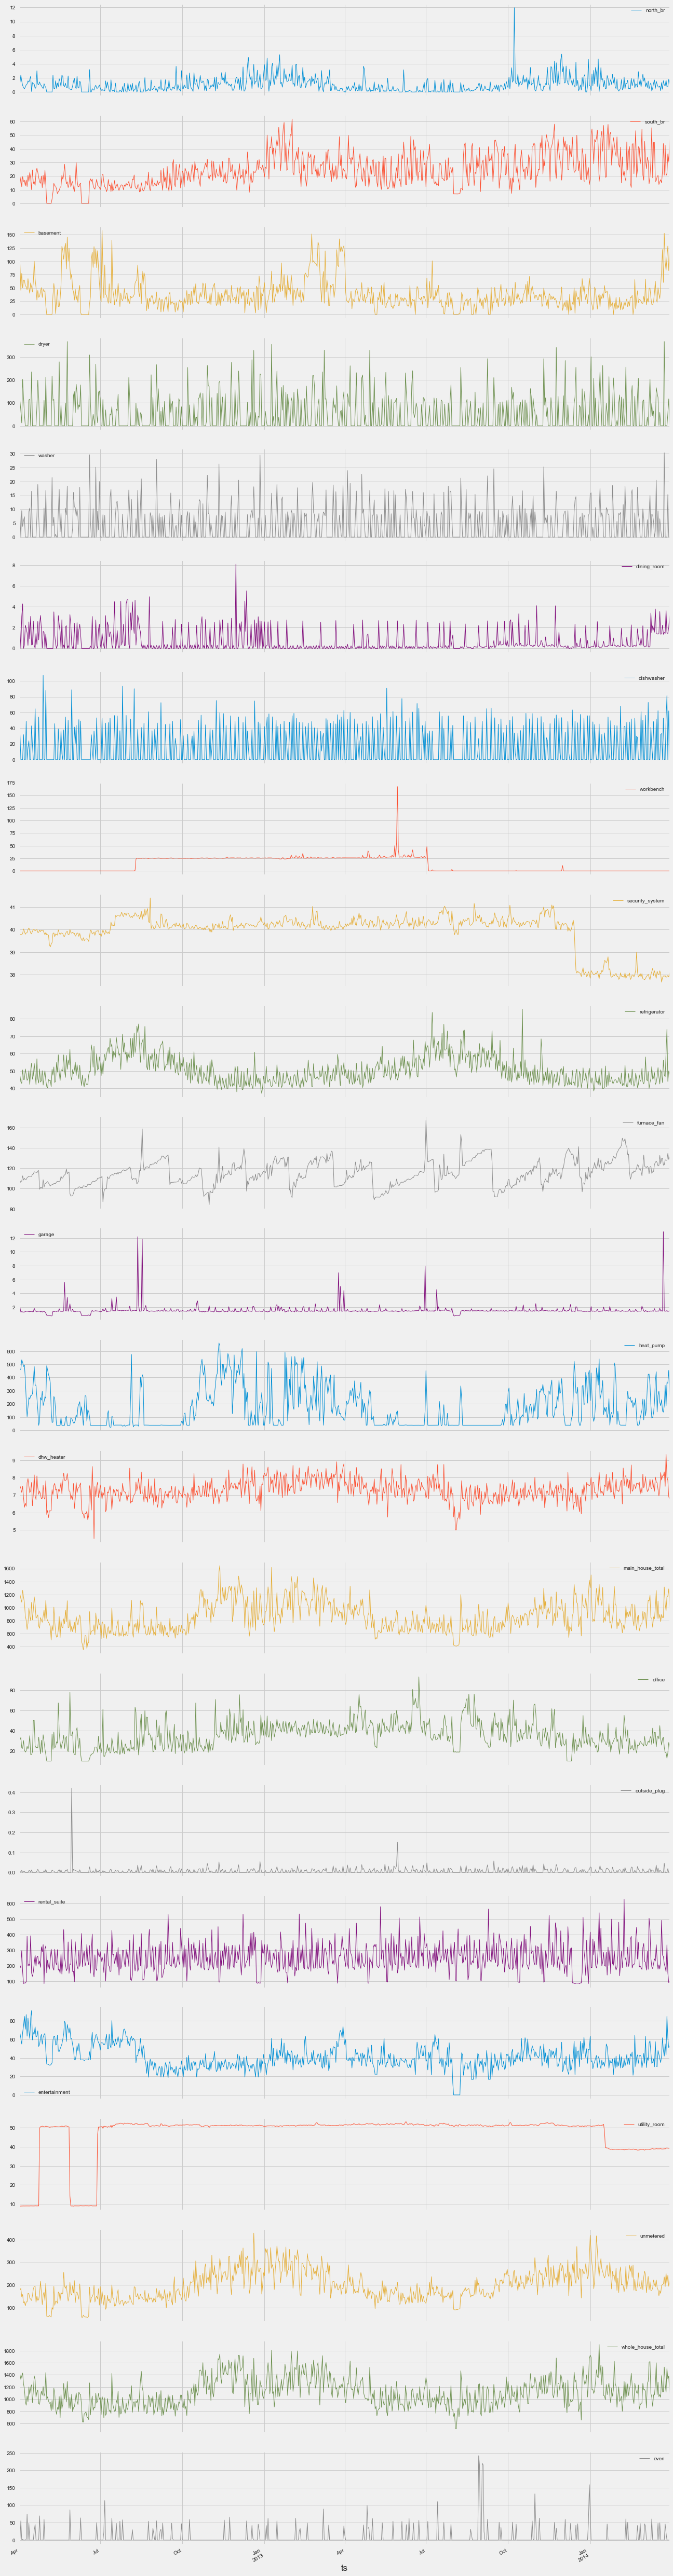

In [21]:
# time series line plot of each power column
df[power_cols].resample('D').mean().plot(subplots=True,linewidth=1,layout=(23,1),figsize=(20,100));

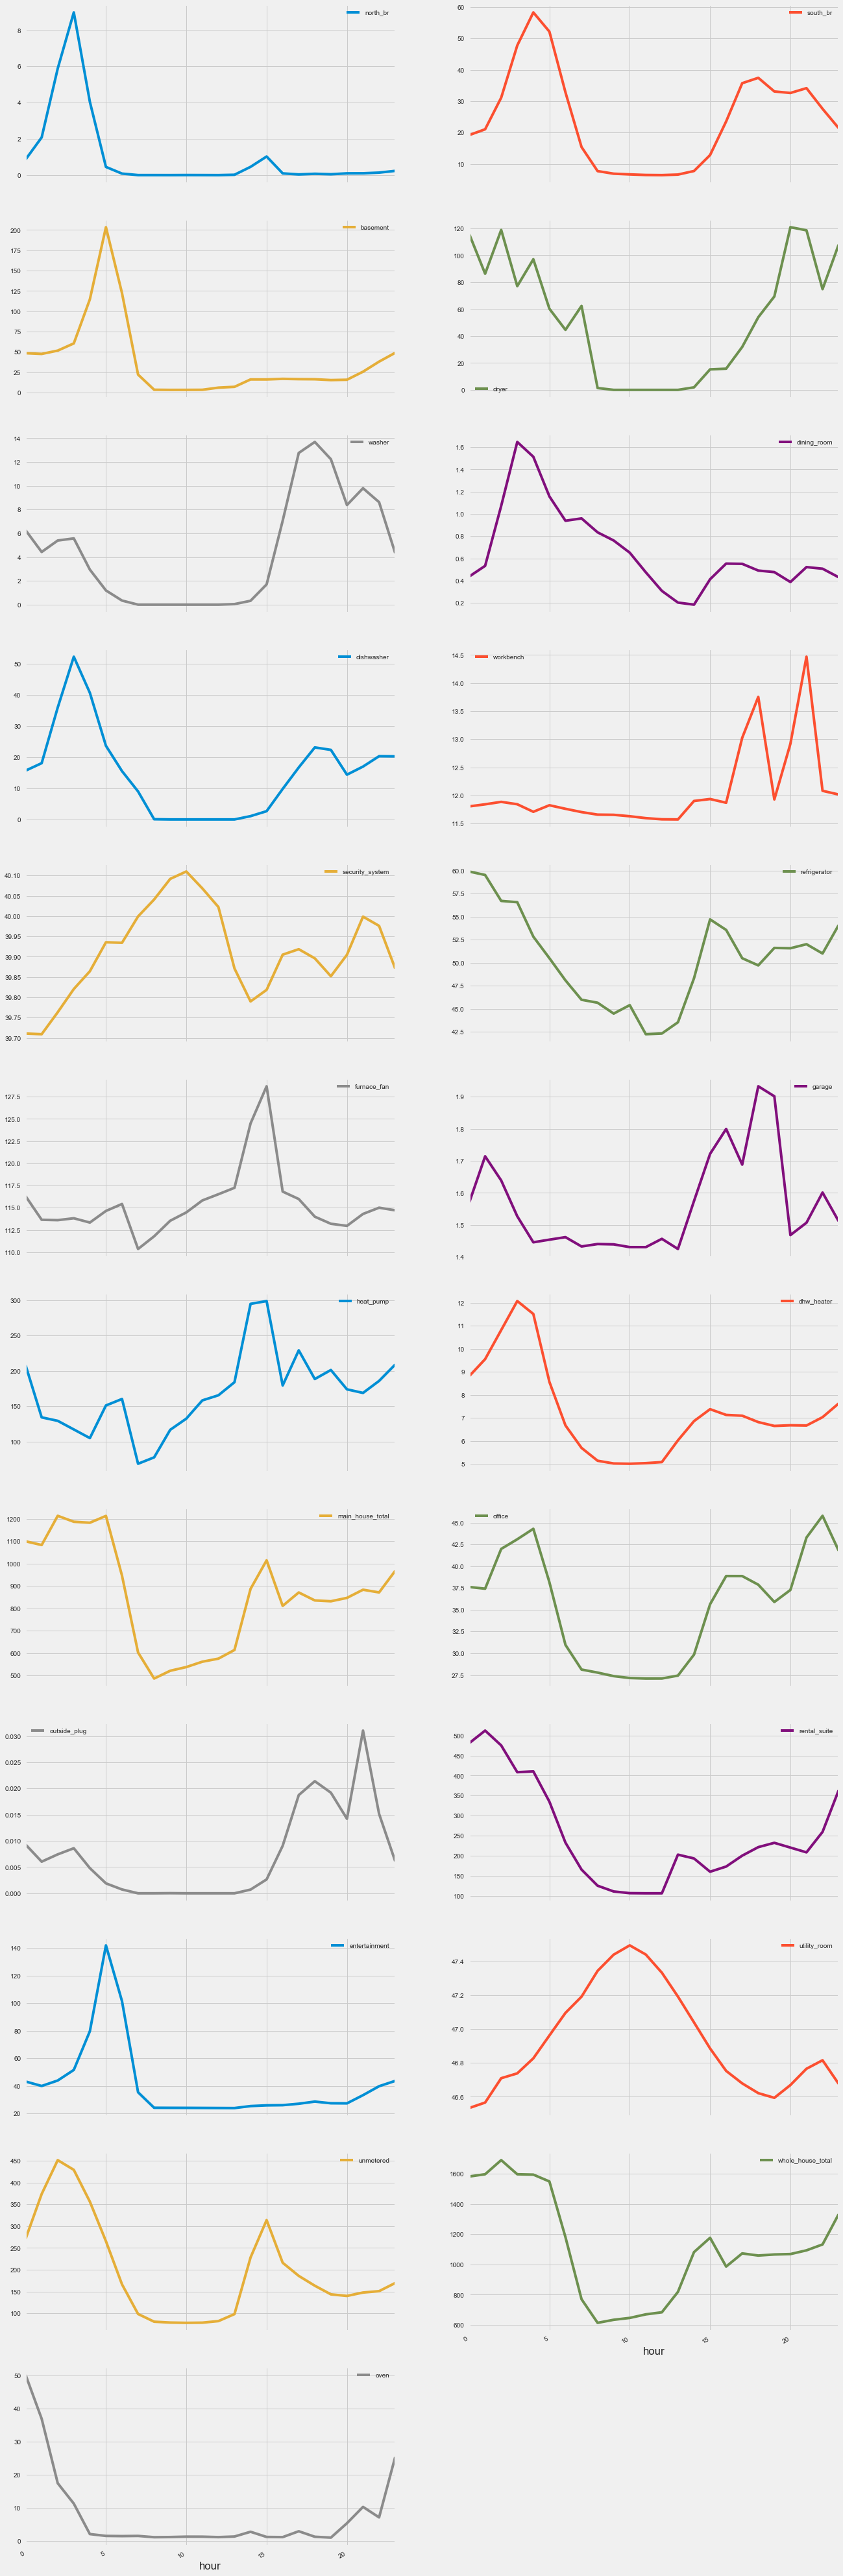

In [58]:
# each power_col plotted against the hour
plot_cols = list(power_cols)
plot_cols.append('hour')
a = df[plot_cols].groupby('hour').mean()
a.plot(subplots=True, layout=(12,2),sharex=True,figsize=(20,80));

In [150]:
# each power_col plotted against the day of the week
# not really useful

# plot_cols = list(power_cols)
# plot_cols.append('dow')
# df[plot_cols].groupby('dow').mean().plot(subplots=True, layout=(12,2),sharex=True,figsize=(20,80));

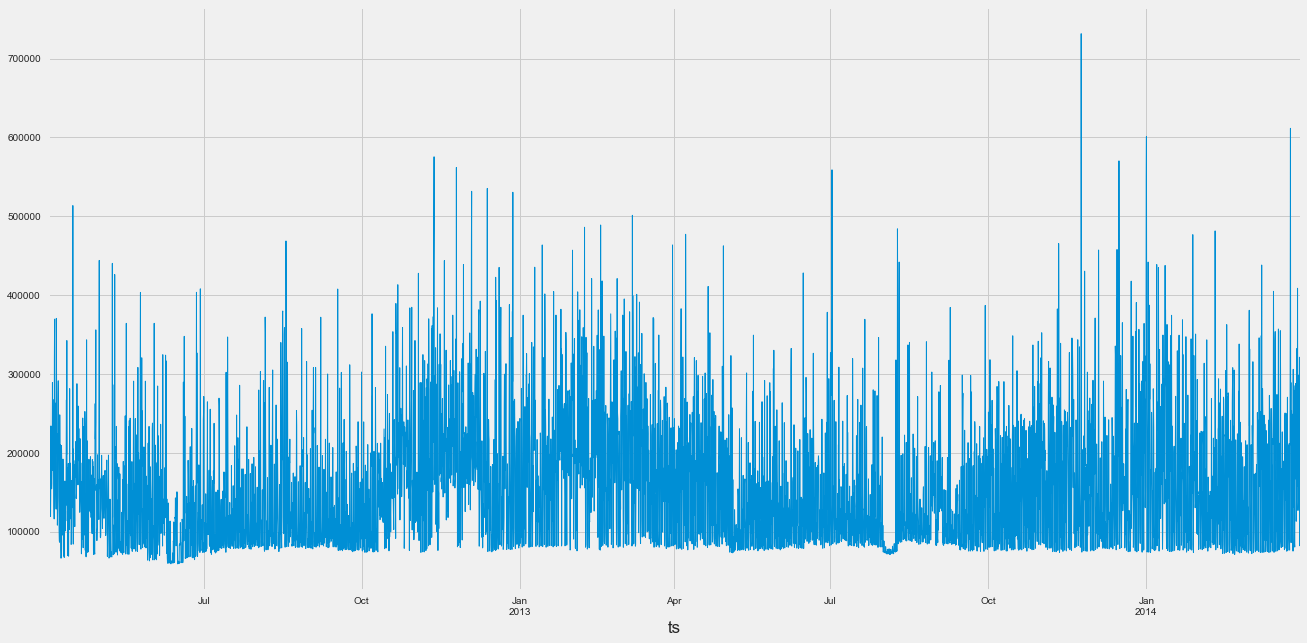

In [45]:
df['main_house_total'].resample('3H').sum().plot(linewidth=1,figsize=(20,10));

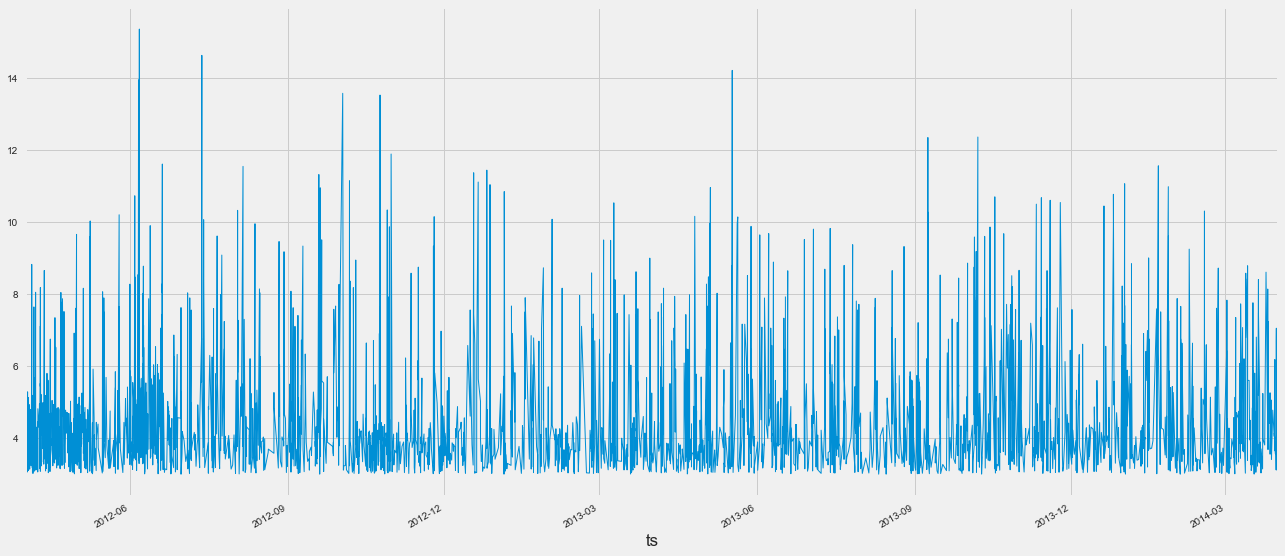

In [63]:
df['mht_pct'][df['mht_pct']>3].plot(linewidth=1,figsize=(20,10));

washer


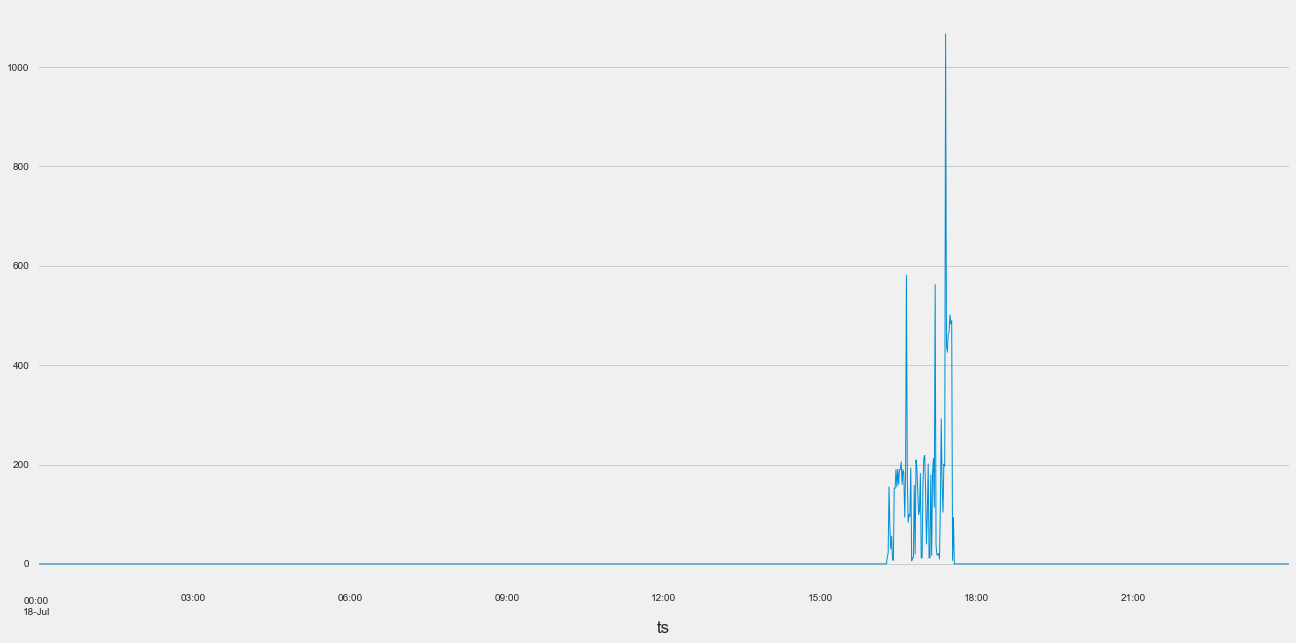

In [115]:
lbl = power_cols[4]
mask = (df.index.week==29)&(df.index.year==2013)&(df.index.day==18)
print(lbl)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
# df['main_house_total'][mask].plot(); # plot this on the secondary y axis as an overlay

In [155]:
# maybe plot ^ as a scatter plot of power vs. hour to see only when points jump? 
# need a better way for filtering out values that are basically 0

dishwasher


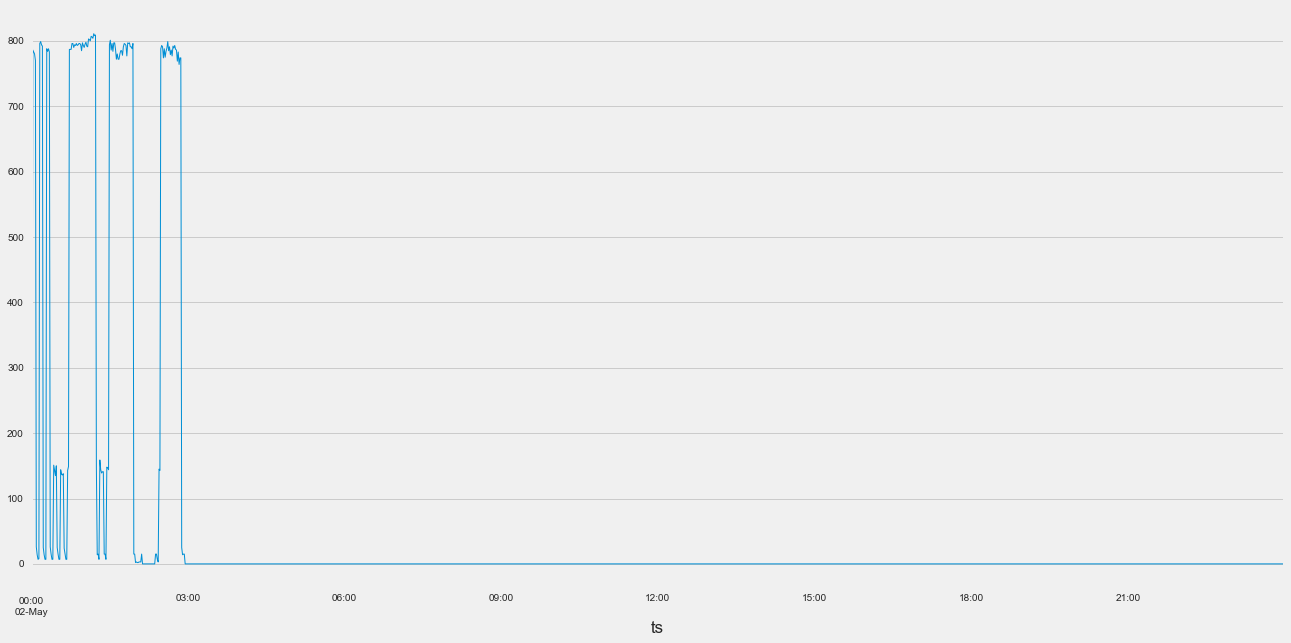

In [50]:
lbl = 'dishwasher'
mask = (df.index.week==18)&(df.index.year==2013)&(df.index.day==2)
print(lbl)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));

## Scatterplots

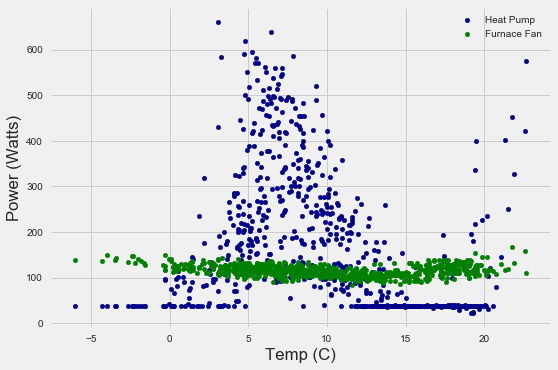

In [60]:
ax = df.resample('D').mean().plot.scatter('Temp (C)','heat_pump',color='DarkBlue',label='Heat Pump');
df.resample('D').mean().plot.scatter('Temp (C)','furnace_fan',color='Green',label='Furnace Fan',ax=ax);
ax.set_ylabel('Power (Watts)');

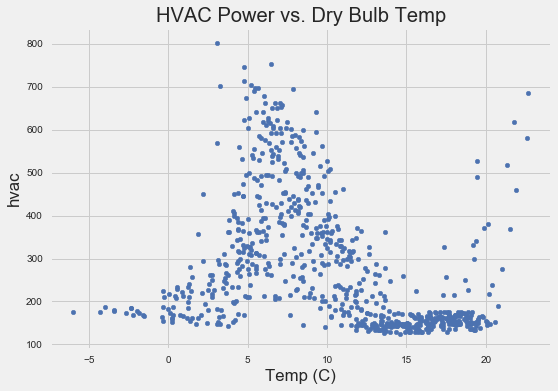

In [8]:
df['hvac'] = df['furnace_fan']+df['heat_pump'];
ax = df.resample('D').mean().plot.scatter('Temp (C)','hvac');
ax.set_title('HVAC Power vs. Dry Bulb Temp');
# once it gets cold enough they must start using natural gas
# furnace fan only for circulation

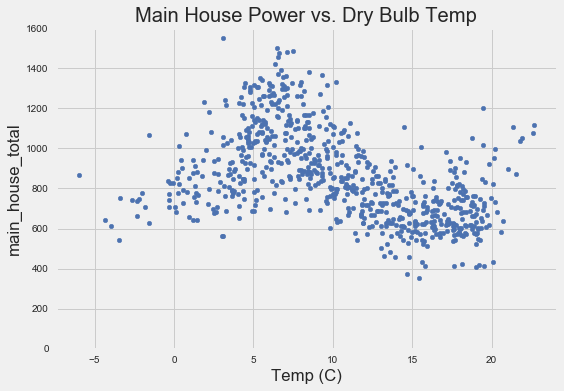

In [156]:
ax = df.resample('D').mean().plot.scatter('Temp (C)','main_house_total');
ax.set_ylim(0,1600);
ax.set_title('Main House Power vs. Dry Bulb Temp');

In [ ]:
# how to iterate through series
for idx, row in df.loc['2014-03-31 23:30':,'main_house_total'].iteritems(): 
    print(row) # print row
    print(idx+pd.Timedelta(minutes=1)) # print index and add one minute
    df.pct_change(1)

dishwasher


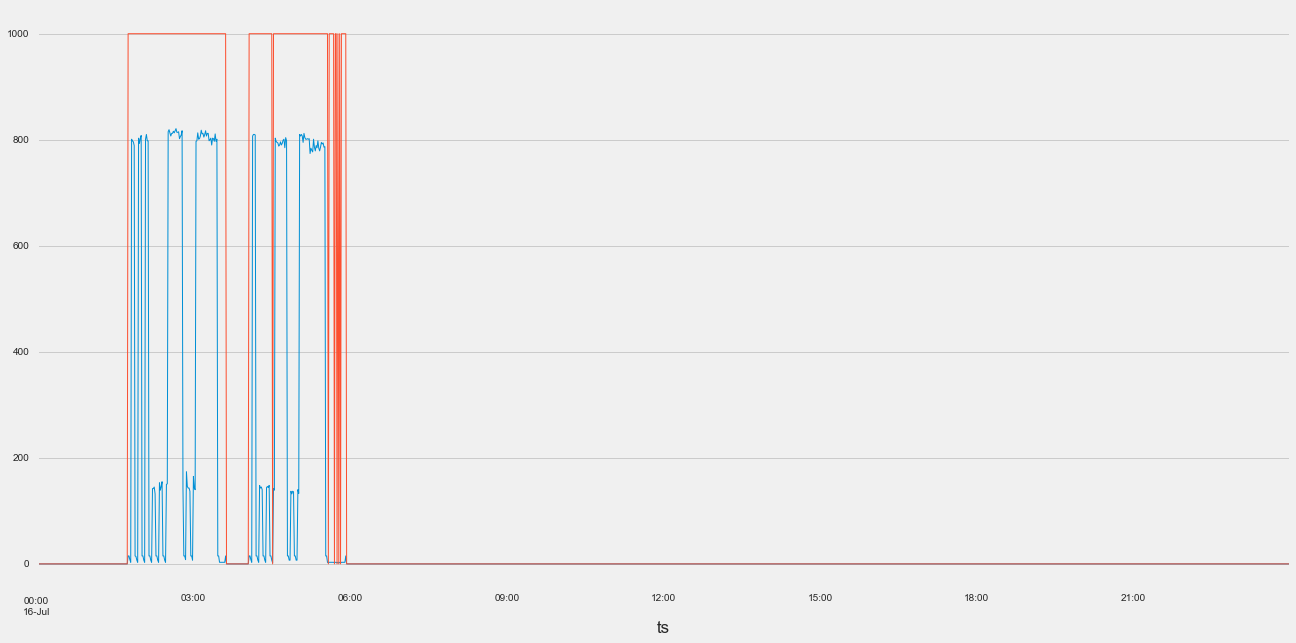

In [148]:
lbl = 'dishwasher'
thresh = df[lbl].mean()*0.2
df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x > thresh else 0)*1000
mask = (df.index.week==29)&(df.index.year==2013)&(df.index.day==16)
print(lbl)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_on'][mask].plot(linewidth=1,figsize=(20,10));

### Ideas and questions

Main meter
1. How to use hour/minute of day?
2. How to use day of week?
3. How to use business hours/holidays?
4. How to use season of year?
5. How to find signal from weather dependent loads in main meter?
6. How to use percent change? 1 or 1+ intervals forward? backward intervals? 
7. How to use magnitude of power increase/decrease?
8. Is there any value in smoothing time intervals to help see "larger" trends instead of just the micro-changes?
9. Is there a way to see a trend and then go back and label what was happening? For example, a dishwasher could look similar to a fridge, except the fridge runs a lot and the dishwasher doesn't. 

ON/OFF Appliances (dishwasher, oven, dryer, washer)
* I expect the signal from these appliances to be easy-ish to find since they are either OFF and have nearly 0 load or  ON and have high loads
* These appliances have relatively large loads when they run which should be useful, especially things that use resistance heating (everything but washer)
* These appliances seem to cycle very rapidly when running
* I expect these appliances to be used primarly during non business hours and mostly at night/weekends (Double check data set description but I'm pretty sure both parents in the household worked)


1. What's the best way to find ON/OFF? percent change? Greater than 0 (or some other small number)?
2. Some ON/OFF appliances are a little "messy" - smooth out?

ON/OFF with Plug Loads a.k.a. "Controlled" (north_br,south_br,basement,dining_room,workbench,
refrigerator,garage,office,outside_plug,rental_suite,entertainment,utility_room)
* I expect the signal from these appliances be pretty hard to find because their usage is pretty random. 
* Some easy to find loads might include: bedroom lights at night, dining room at night (or morning), entertainment at night/weekend, office at night/weekends.
* We might be able to pick out these loads since their relative magnitude is small compared to many other things (basically just lights, charging things, and running TV/XBOX)
* I expect these loads to be used primarily during non business hours and mostly at night/weekends


1. How to use magnitude of power increase?
2. How to handle "base" plug loads
3. How to separate these appliances from "on-demand" appliances?

Steady State Appliances (security system)
* I think we can ignore because they are just constant loads and will therefore have no obvious signal. Plus it's not like someone is going to stop running their 40W security system to save energy.

On Demand Appliances a.k.a. "Cycling" (DHW heater, refrigerator)
* I expect these appliances to cycle ON/OFF a lot based on demand
* I expect primary demand to be between 5 and 11 PM and on weekends
* The DHW heater and refrigerator are pretty small loads when on (40 and 150 W respective)


1. How to use mangitude of power increase
2. How to separate cycling appliances from "controlled" appliances

Weather Dependent and On-Demand Appliances (furnace, heat pump)
* I expect these appliances to use more energy when it's very cold or very hot
* I expect primary demand to be between 5 PM and 9 AM and on weekends


1. How to identify weather dependent loads?
2. How to separate from "on-demand" loads and "controlled" loads

Other (unmetered, whole house total)
* Does either of these have any value?

To handle base loads/plug loads: Take the minimum of the main power meter and subtract it. This would be the same as taking the min of each appliance and subtracting it out. This would allow analysis of only the rises and falls for each appliance.

To handle weather dependent loads: Find changes in main power meter and compare to change in weather. If they have correlation then likely weather dependent